In [ ]:
from geopy.distance import distance
from google.colab import drive
import json
import matplotlib
matplotlib.rcParams['figure.figsize'] = [5, 4]
matplotlib.rcParams['font.size'] = 9
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.impute import KNNImputer

In [ ]:
# %pip install geopandas

In [ ]:
# import geopandas as gpd
# from geopandas import GeoDataFrame
# from shapely.geometry import Point

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


# Data preprocessing

## Data merging
Preprocess data and create a list of reasonable OD pairs.

In [ ]:
place = pd.read_csv('/content/drive/My Drive/CMAP/gps_place.csv', low_memory=False)
loc = pd.read_csv('/content/drive/My Drive/CMAP/location.csv', low_memory=False)

In [ ]:
pl = place.query('mode_imputed == [1, 2, 3, 4] and travtime > 0 and distance > 0')
pl = pl[['sampno', 'perno', 'locno', 'arrtime', 'deptime', 'travtime', 'distance', 'mode_imputed', 'fare', 'pkamt']]
l = loc.query('latitude != -9')[['sampno', 'locno', 'latitude', 'longitude']]

pl_l = pd.merge(pl, l, left_on=['sampno', 'locno'], right_on=['sampno', 'locno'], how='inner')

In [ ]:
pers = pd.read_csv('/content/drive/My Drive/CMAP/person.csv', low_memory=False)
hh = pd.read_csv('/content/drive/My Drive/CMAP/household.csv', low_memory=False)

In [ ]:
p = pers.query('age > 0 and sex > 0 and educ > 0')[['sampno', 'perno', 'age', 'sex', 'educ']]
h = hh.query('hhinc > 0')[['sampno', 'hhsize', 'hhveh', 'hhinc']]

pers_hh = pd.merge(p, h, left_on='sampno', right_on='sampno', how='inner')

In [ ]:
data = pd.merge(pers_hh, pl_l, left_on=['sampno', 'perno'], right_on=['sampno', 'perno'], how='inner')
data = data.rename(columns={'latitude': 'a_lat', 'longitude': 'a_lon'})

In [ ]:
for i in range(1, len(data)):
    if data.loc[i-1, 'sampno'] == data.loc[i, 'sampno'] and data.loc[i-1, 'perno'] == data.loc[i, 'perno']:
        data.loc[i, 'd_lat'] = data.loc[i-1, 'a_lat']
        data.loc[i, 'd_lon'] = data.loc[i-1, 'a_lon']
    else:
        data.loc[i, 'd_lat'] = np.nan
        data.loc[i, 'd_lon'] = np.nan

In [ ]:
df = data.query('d_lat != a_lat and d_lon != a_lon').dropna().reset_index(drop=True)
len(df)

34606

In [ ]:
od = []
for i in range(len(df)):
    pair = (str(df.loc[i, 'd_lat'])+','+str(df.loc[i, 'd_lon']), str(df.loc[i, 'a_lat'])+','+str(df.loc[i, 'a_lon']))
    if pair not in od:
        od.append(pair)
len(od)

26361

## Plotting data coverage
Plot data coverage of the first 5000 OD pairs.

In [ ]:
# d_lat = [float(od[i][0].split(',')[0]) for i in range(len(od))]
# d_lon = [float(od[i][0].split(',')[1]) for i in range(len(od))]
# a_lat = [float(od[i][1].split(',')[0]) for i in range(len(od))]
# a_lon = [float(od[i][1].split(',')[1]) for i in range(len(od))]

# od_smp = od[:5000]
# d_lat_smp = [float(od_smp[i][0].split(',')[0]) for i in range(5000)]
# d_lon_smp = [float(od_smp[i][0].split(',')[1]) for i in range(5000)]
# a_lat_smp = [float(od_smp[i][1].split(',')[0]) for i in range(5000)]
# a_lon_smp = [float(od_smp[i][1].split(',')[1]) for i in range(5000)]

In [ ]:
# def od_plot_all(lon, lat, tag, color):
#     geo = [Point(xy) for xy in zip(lon, lat)]
#     gdf = GeoDataFrame(geometry=geo)
#     gdf.crs = 'epsg:4326'

#     data = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
#     ax = data.plot(figsize=(8, 7), color='gray', edgecolor='black', alpha=.3)
#     ax.set_xlim(-126, -66)
#     ax.set_ylim(24, 50)
#     gdf.plot(ax=ax, marker='.', color=color, alpha=.3, markersize=10, label=tag)
#     ax.set_xlabel('Longitude')
#     ax.set_ylabel('Latitude')
#     ax.legend()

In [ ]:
# od_plot_all(d_lon_smp, d_lat_smp, 'Origin (Sample)', 'red')

In [ ]:
# def od_plot(lon, lat, tag, color):
#     geo = [Point(xy) for xy in zip(lon, lat)]
#     gdf = GeoDataFrame(geometry=geo)
#     gdf.crs = 'epsg:4326'

#     data = gpd.read_file('/content/drive/My Drive/CMAP/chicago.shp')
#     ax = data.plot(figsize=(8, 7), color='gray', edgecolor='black', alpha=.3)
#     ax.set_xlim(-88, -87.4)
#     ax.set_ylim(41.6, 42.1)
#     gdf.plot(ax=ax, marker='.', color=color, alpha=.3, markersize=10, label=tag)
#     ax.set_xlabel('Longitude')
#     ax.set_ylabel('Latitude')
#     ax.legend()

In [ ]:
# od_plot(d_lon_smp, d_lat_smp, 'Origin (Sample)', 'red')
# od_plot(a_lon_smp, a_lat_smp, 'Destination (Sample)', 'green')

In [ ]:
# od_plot(d_lon, d_lat, 'Origin', 'red')
# od_plot(a_lon, a_lat, 'Destination', 'green')

# Data completion

## Google Directions API
Use Google API to extract distances and durations for the OD pairs.

In [ ]:
# usr_key_google = ''
# txt = []

# for i in range():
#     if i % 100 == 0:
#         print(f'Ite = {i}')
#     o_coor = od[i][0]
#     d_coor = od[i][1]
#     url = 'https://maps.googleapis.com/maps/api/directions/json?' + \
#           'origin=' + o_coor + '&destination=' + d_coor + \
#           '&key=' + usr_key_google + \
#           '&mode=walking'
#     res = requests.get(url)
#     text = json.loads(res.content)
#     txt.append(text)

# with open('directions_walking.json', 'a') as f:
#     json.dump(txt, f, indent=2)

In [ ]:
with open('/content/drive/My Drive/CMAP/directions_auto.json', 'r') as f:
    txt1 = json.load(f)
with open('/content/drive/My Drive/CMAP/directions_walk.json', 'r') as f:
    txt2 = json.load(f)
with open('/content/drive/My Drive/CMAP/directions_train.json', 'r') as f:
    txt3 = json.load(f)
with open('/content/drive/My Drive/CMAP/directions_bike.json', 'r') as f:
    txt4 = json.load(f)

In [ ]:
dt1, tt1, dt2, tt2, dt3, tt3, dt4, tt4 = [[] for i in range(8)]

for i in range(len(txt1)):
    try:
        dt1.append(txt1[i]['routes'][0]['legs'][0]['distance']['value'] / 1e3)
        tt1.append(txt1[i]['routes'][0]['legs'][0]['duration']['value'] / 60)
    except:
        dt1.append(np.nan)
        tt1.append(np.nan)
    try:
        dt2.append(txt2[i]['routes'][0]['legs'][0]['distance']['value'] / 1e3)
        tt2.append(txt2[i]['routes'][0]['legs'][0]['duration']['value'] / 60)
    except:
        dt2.append(np.nan)
        tt2.append(np.nan)
    try:
        dt3.append(txt3[i]['routes'][0]['legs'][0]['distance']['value'] / 1e3)
        tt3.append(txt3[i]['routes'][0]['legs'][0]['duration']['value'] / 60)
    except:
        dt3.append(np.nan)
        tt3.append(np.nan)
    try:
        dt4.append(txt4[i]['routes'][0]['legs'][0]['distance']['value'] / 1e3)
        tt4.append(txt4[i]['routes'][0]['legs'][0]['duration']['value'] / 60)
    except:
        dt4.append(np.nan)
        tt4.append(np.nan)

In [ ]:
for i in df.index:
    pair = (str(df.loc[i, 'd_lat'])+','+str(df.loc[i, 'd_lon']), str(df.loc[i, 'a_lat'])+','+str(df.loc[i, 'a_lon']))
    idx = od.index(pair)
    try:
        df.loc[i, 'auto_dist'] = dt1[idx]
        df.loc[i, 'auto_time'] = tt1[idx]
    except:
        df.loc[i, 'auto_dist'] = np.nan
        df.loc[i, 'auto_time'] = np.nan
    try:
        df.loc[i, 'walk_dist'] = dt2[idx]
        df.loc[i, 'walk_time'] = tt2[idx]
    except:
        df.loc[i, 'walk_dist'] = np.nan
        df.loc[i, 'walk_time'] = np.nan
    try:
        df.loc[i, 'train_dist'] = dt3[idx]
        df.loc[i, 'train_time'] = tt3[idx]
    except:
        df.loc[i, 'train_dist'] = np.nan
        df.loc[i, 'train_time'] = np.nan
    try:
        df.loc[i, 'bike_dist'] = dt4[idx]
        df.loc[i, 'bike_time'] = tt4[idx]
    except:
        df.loc[i, 'bike_dist'] = np.nan
        df.loc[i, 'bike_time'] = np.nan

We find that in many cases, OD distances in the CMAP data are very different from what Google API provides. We calculate the great-circle distance for all OD pairs and study only _reasonable_ trips, which should not have abnormal distance, time, or cost values.

In [ ]:
df['gc_dist'] = [distance((df.loc[i, 'd_lat'], df.loc[i, 'd_lon']), (df.loc[i, 'a_lat'], df.loc[i, 'a_lon'])).km for i in range(len(df))]
df1 = df.query('gc_dist <= 50 and train_time < 300 and fare < 50 and pkamt < 50').copy()
df1.shape

(26099, 29)

In [ ]:
place1 = pd.read_csv('/content/drive/My Drive/CMAP/place.csv', low_memory=False)
df2 = pd.merge(df1, place1[['sampno', 'perno', 'locno', 'plaza_total']].drop_duplicates(subset=['sampno', 'perno', 'locno']),
               left_on=['sampno', 'perno', 'locno'], right_on=['sampno', 'perno', 'locno'], how='left')

In [ ]:
# Train cost
df2.loc[df2['fare'] < 0, 'fare'] = np.nan

# Parking cost
df2.loc[df2['pkamt'] < 0, 'pkamt'] = np.nan

# Driving cost
df2.loc[df2['plaza_total'] < 0, 'plaza_total'] = np.nan

## Data imputation
Perform the $K$-nearest neighbors algorithm on the missing data, and finally export the processed dataset.

In [ ]:
ls_var = ['auto_dist', 'auto_time', 'walk_dist', 'walk_time', 'train_dist', 'train_time', 'fare',
          'bike_dist', 'bike_time', 'pkamt', 'plaza_total']
imputer = KNNImputer(n_neighbors=30)
df2[ls_var] = imputer.fit_transform(df2[ls_var])

In [ ]:
df2['auto_cost'] = df2['pkamt'] + df2['plaza_total']
df2 = df2.rename(columns={'fare': 'train_cost'})
# df2['adt'] = (df2['age'] >= 18).astype(int)

df2[['auto_time', 'auto_cost', 'walk_time', 'train_time', 'train_cost', 'bike_time']].describe()

,auto_time,auto_cost,walk_time,train_time,train_cost,bike_time
count,26099.000000,26099.000000,26099.000000,26099.000000,26099.000000,26099.000000
mean,13.306890,8.767925,104.239406,49.495758,2.551469,31.972235
std,9.391752,4.105220,123.512195,40.287428,0.390145,37.239294
min,0.166667,1.178333,3.166667,3.166667,0.000000,0.783333
25%,6.666667,5.844000,30.150000,22.725000,2.333333,9.800000
50%,10.383333,6.572333,58.600000,38.216667,2.483333,18.233333
75%,17.216667,11.056667,122.383333,59.466667,2.608333,37.258333
max,99.350000,48.238333,2062.616667,297.150000,10.000000,555.466667


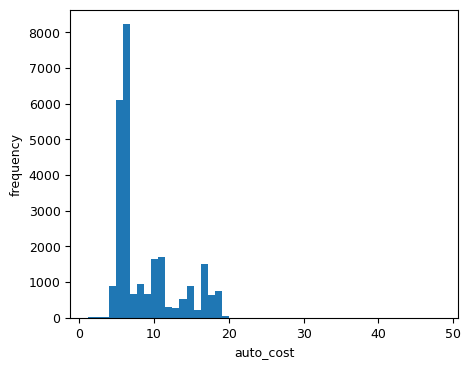

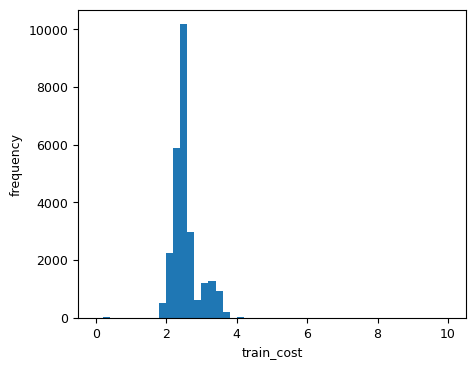

In [ ]:
for i in ['auto_cost', 'train_cost']:
    plt.hist(df2[i], bins=50)
    plt.xlabel(i)
    plt.ylabel('frequency')
    plt.show()

In [ ]:
df2['male'] = (df2['sex'] == 1).astype(int)
# df2['male'].value_counts()

In [ ]:
# df2['high_inc'] = (df2['hhinc'] > 7).astype(int)
# df2['high_inc'].value_counts()

In [ ]:
# df2['high_edu'] = df2['educ'].isin([5, 6]).astype(int)
# df2['high_edu'].value_counts()

In [ ]:
df2['active_time'] = (df2['walk_time'] + df2['bike_time']) / 2
df2 = df2.drop(columns=['walk_time', 'bike_time'])

In [ ]:
df2['mode'] = df2['mode_imputed'].replace(1, 0).replace(3, 1).replace(4, 2)
df2['mode'].value_counts()

0    18029
2     5366
1     2704
Name: mode, dtype: int64

# Data export

In [ ]:
X = df2[['age', 'male', 'educ', 'hhsize', 'hhveh', 'hhinc', 'auto_time', 'auto_cost', 'train_time', 'train_cost', 'active_time', 'mode']]
X.to_csv('/content/drive/My Drive/CMAP/chicago_processed.csv')